In [17]:
import numpy as np
import pandas as pd
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM
import matplotlib.pyplot as plt

from statsmodels.formula.api import mixedlm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input


In [18]:
df = pd.read_csv("/data01/bgutman/MRI_data/PPMI/data_ppmi_pd.csv")
df_K = pd.read_csv("/data01/bgutman/LEGACY/Skoltech/datasets/Connectomes/mean_NORM_con_full.csv")

## remove non-longitudinal observations
print("original size:", df.shape)
relevant_cols = [col for col in df.columns if col.startswith(('L_', 'R_')) and ('_thickavg' in col or '_thickavg_resid' in col)]
relevant_cols += ["MCATOT", "TD_score", "PIGD_score"]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=relevant_cols)

print("after drop na", df.shape)
subj_counts = df['subj_id'].value_counts()
num_unique = (subj_counts == 1).sum()
print("one time subj_id:", num_unique)

longitudinal_ids = subj_counts[subj_counts > 1].index
df = df[df['subj_id'].isin(longitudinal_ids)].copy()
df = df.drop_duplicates(subset=["subj_id", "time"])
print("after drop dupes", df.shape)

small_region_set = ['L_inferiorparietal_thickavg',
'R_inferiorparietal_thickavg',
'L_inferiortemporal_thickavg',
'R_inferiortemporal_thickavg',
'L_precuneus_thickavg',
'R_precuneus_thickavg',
'L_isthmuscingulate_thickavg',
'R_isthmuscingulate_thickavg',
'L_lateraloccipital_thickavg',
'R_lateraloccipital_thickavg']


X = df[small_region_set]
X_resid = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg_resid'))]]

cool_idx = [6, 40, 7, 41, 23, 57, 8, 42, 9, 43]

X = X.to_numpy()
#X = X[:,cool_idx]

X_resid = X_resid.to_numpy()

print("nans in X:", np.isnan(X).sum())
print("infs in X:", np.isinf(X).sum())

print("nans X_resid:", np.isnan(X_resid).sum())
print("infs X_resid:", np.isinf(X_resid).sum())

## connectivity matrix to numpy
K = df_K.drop(df_K.columns[0], axis=1).to_numpy()
np.fill_diagonal(K, 0)
print(K.shape, type(K))

# normalization
row_sums = K.sum(axis=1)
median_row_sum = np.median(row_sums)
K = K / median_row_sum

K = np.take(np.take(K,cool_idx,axis=0), cool_idx, axis=1)

t_max = 20
step = 0.001

print(K.shape)

print("X.size: ", X.shape, "X_resid.size: ", X_resid.shape)

ids = df["subj_id"].to_numpy()
dt = df["time"].to_numpy()/12 # convert to years
#cog = df["MCATOT"].values#,"TD_score","PIGD_score"]].values
cog = df[["MCATOT","TD_score","PIGD_score"]].to_numpy()

print("nans in cog:", np.isnan(cog).sum())
print("infs in cog:", np.isinf(cog).sum())

original size: (880, 250)
after drop na (868, 250)
one time subj_id: 227
after drop dupes (504, 250)
nans in X: 0
infs in X: 0
nans X_resid: 0
infs X_resid: 0
(68, 68) <class 'numpy.ndarray'>
(10, 10)
X.size:  (504, 10) X_resid.size:  (504, 68)
nans in cog: 0
infs in cog: 0


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: time_years
No. Observations: 504     Method:             REML      
No. Groups:       146     Scale:              2.0152    
Min. group size:  2       Log-Likelihood:     -900.0355 
Max. group size:  4       Converged:          Yes       
Mean group size:  3.5                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.497    0.690  2.169 0.030  0.145  2.850
MCATOT        -0.002    0.024 -0.093 0.926 -0.050  0.046
PIGD_score     0.127    0.032  3.994 0.000  0.065  0.189
TD_score      -0.010    0.016 -0.607 0.544 -0.041  0.022
Group Var      0.000                                    



/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


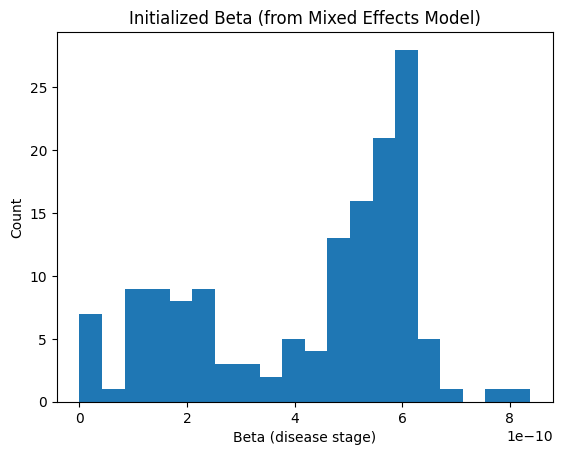

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm
import pandas as pd

# Select relevant columns
df_cog = df[["subj_id", "time", "MCATOT", "PIGD_score", "TD_score"]].copy()

# Convert time to years
df_cog["time_years"] = df_cog["time"] / 12

# Drop rows with missing values in any of the relevant columns
df_cog.dropna(subset=["time_years", "MCATOT", "PIGD_score", "TD_score"], inplace=True)

# Fit mixed effects model: time as response, others as predictors
model = mixedlm("time_years ~ MCATOT + PIGD_score + TD_score", 
                data=df_cog, 
                groups=df_cog["subj_id"],
                re_formula="1")  # random intercept only

result = model.fit()
print(result.summary())

# Extract random intercepts as proxy for disease stage (lower intercept ~ earlier stage)
random_effects = result.random_effects
id_to_intercept = {pid: re["Group"] for pid, re in random_effects.items()}
unique_ids = np.unique(df["subj_id"])
beta_init = np.array([id_to_intercept.get(pid, 0.0) for pid in unique_ids])

if min(beta_init) < 0:
    beta_init += np.abs(min(beta_init))

plt.hist(beta_init, bins=20)
plt.title("Initialized Beta (from Mixed Effects Model)")
plt.xlabel("Beta (disease stage)")
plt.ylabel("Count")
plt.show()


(array([  2.,   1.,   3.,   2.,   3.,   1.,   0.,   0.,   7., 127.]),
 array([11.13297925, 11.23297925, 11.33297925, 11.43297925, 11.53297925,
        11.63297925, 11.73297925, 11.83297925, 11.93297925, 12.03297925,
        12.13297925]),
 <BarContainer object of 10 artists>)

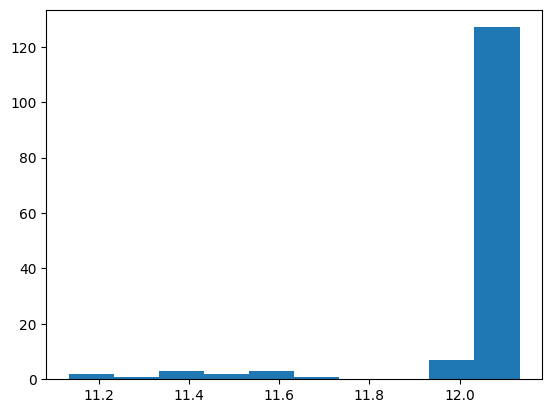

In [27]:
t_max = 30
beta_init = beta_init * 1 / (max(beta_init) - min(beta_init))

plt.hist(beta_init)


In [28]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter10_test"
em_model_0 = EM(num_iterations=2, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.3, lambda_f=0.1, lambda_scalar=0.0)
em_model_0.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init)

prepend complete


100%|██████████| 2/2 [00:04<00:00,  2.48s/it]

Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter10_test.npz


EM(lambda_cog=0.3, lambda_f=0.1, num_iterations=2,
   rng=Generator(PCG64) at 0x7F6876A73140, step=0.001, t_max=30,
   use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
s0:  [2.609 2.643 2.946 2.977 2.588 2.609 2.769 2.793 2.428 2.472]
s_k:  2.977
final theta:
f:  [0.    0.032 0.058 0.062 0.021 0.027 0.074 0.074 0.042 0.   ]
s:  [-0.555 -0.703 -0.544 -0.533 -0.548 -0.546 -0.721 -0.742 -0.561 -0.542]
s0:  [2.878 2.803 3.182 3.216 2.863 2.875 2.926 2.936 2.691 2.768]
s_k:  2.9845884473201467
(31,)
n_zeros: 0


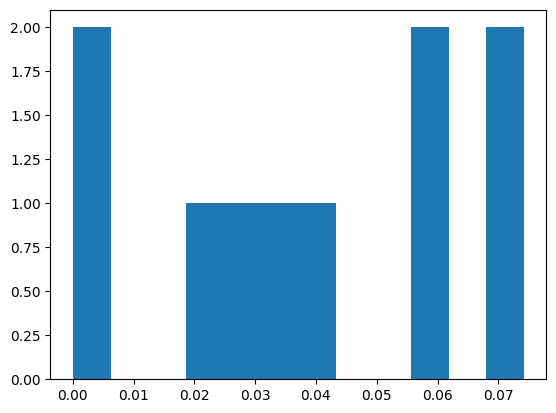


BETA SUMMARY:
beta initial:  [12.133  12.133  11.3585 12.133  12.133  12.133  12.133  11.9718 12.133
 12.133 ]
beta final:  [30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]


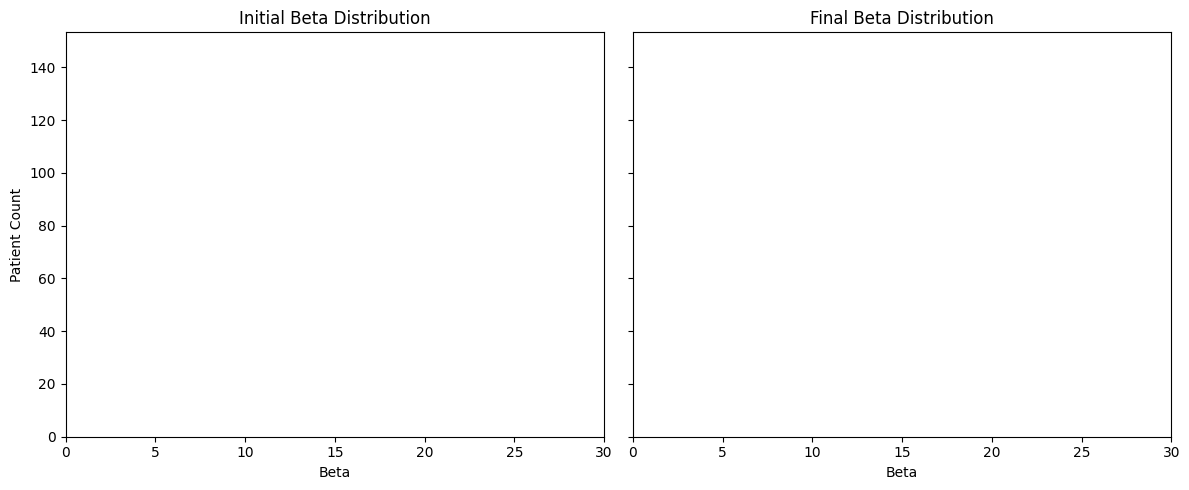

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


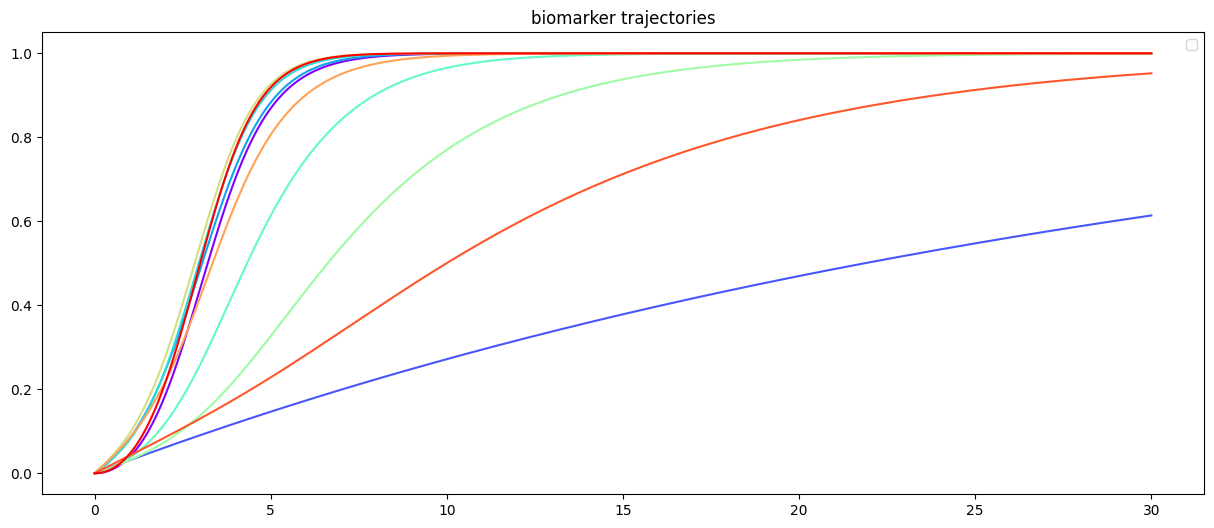

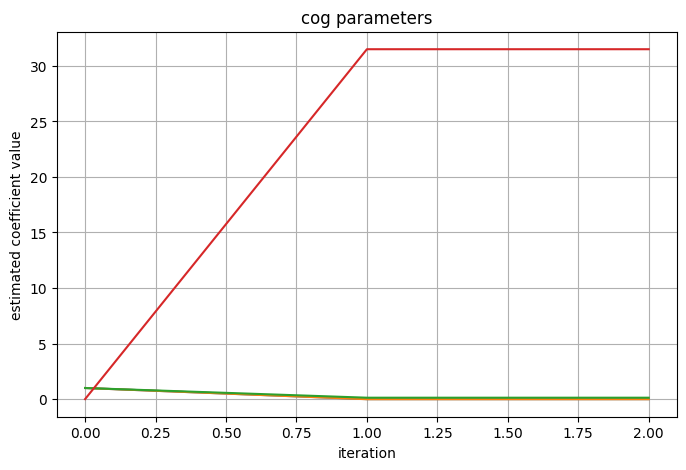

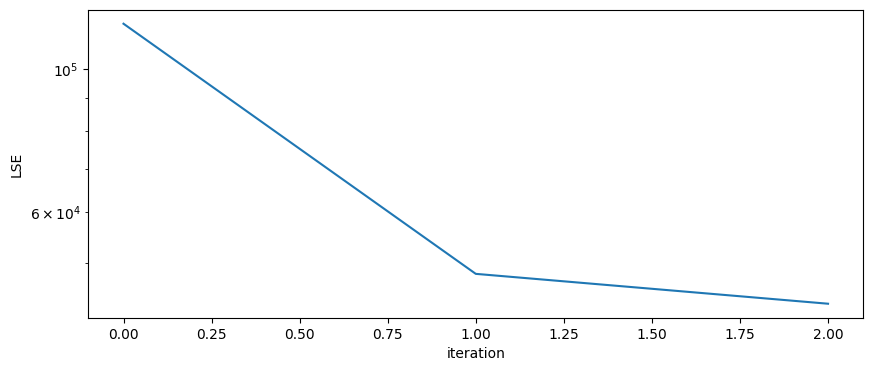

In [29]:
n_biomarkers = 10
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_s0 = final_theta[2*n_biomarkers:3*n_biomarkers]
final_scalar_K = final_theta[-1]

final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers],3))
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers],3))
print("s0: ", np.round(initial_theta[2*n_biomarkers:3*n_biomarkers],3))
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers],3))
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3))
print("s0: ", np.round(final_theta[2*n_biomarkers:3*n_biomarkers],3))
print("s_k: ", final_theta[-1])


print(final_theta.shape)

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0],4))
print("beta final: ", np.round(beta_history[0:10, -1], 4))

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(beta_init, bins=20, color='steelblue', alpha=0.8)
axes[0].set_title("Initial Beta Distribution")
axes[0].set_xlabel("Beta")
axes[0].set_ylabel("Patient Count")
axes[0].set_xlim(0, t_span[-1])

axes[1].hist(beta_history[:,-1], bins=20, color='darkorange', alpha=0.8)
axes[1].set_title("Final Beta Distribution")
axes[1].set_xlabel("Beta")
axes[1].set_xlim(0, t_span[-1])

plt.tight_layout()
plt.show()


plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history)

In [23]:
tmax=40
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk01_betaREG"
em_model_1 = EM(num_iterations=3, t_max=tmax, step=step,
                 use_jacobian=True, lambda_cog=0.3, lambda_f=0.1, lambda_scalar=0.0)
em_model_1.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init)

prepend complete


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:20<00:00,  6.95s/it]

Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk01_betaREG.npz


EM(lambda_cog=0.3, lambda_f=0.1, num_iterations=3,
   rng=Generator(PCG64) at 0x7F6867B68C80, step=0.001, t_max=40,
   use_jacobian=True)

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
s_k:  2.977
final theta:
f:  [0.029 0.01  0.109 0.116 0.099 0.089 0.106 0.113 0.045 0.   ]
s:  [-0.556 -0.933 -0.544 -0.534 -0.549 -0.551 -0.721 -0.743 -0.562 -0.543]
s_k:  2.978686288774894
n_zeros: 0


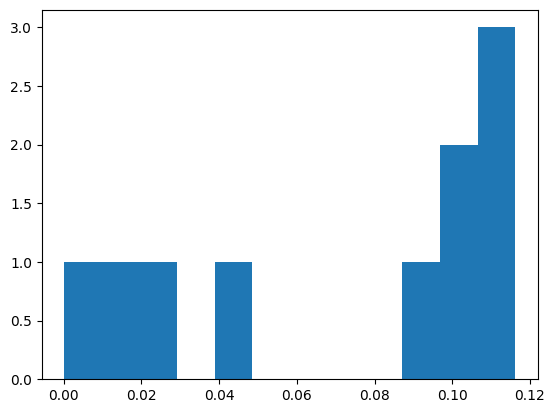

/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()



BETA SUMMARY:
beta initial:  [20. 20. 20. 20. 20. 20. 20. 20. 20. 20.]
beta final:  [40.    40.    37.447 40.    40.    40.    40.    39.469 40.    40.   ]


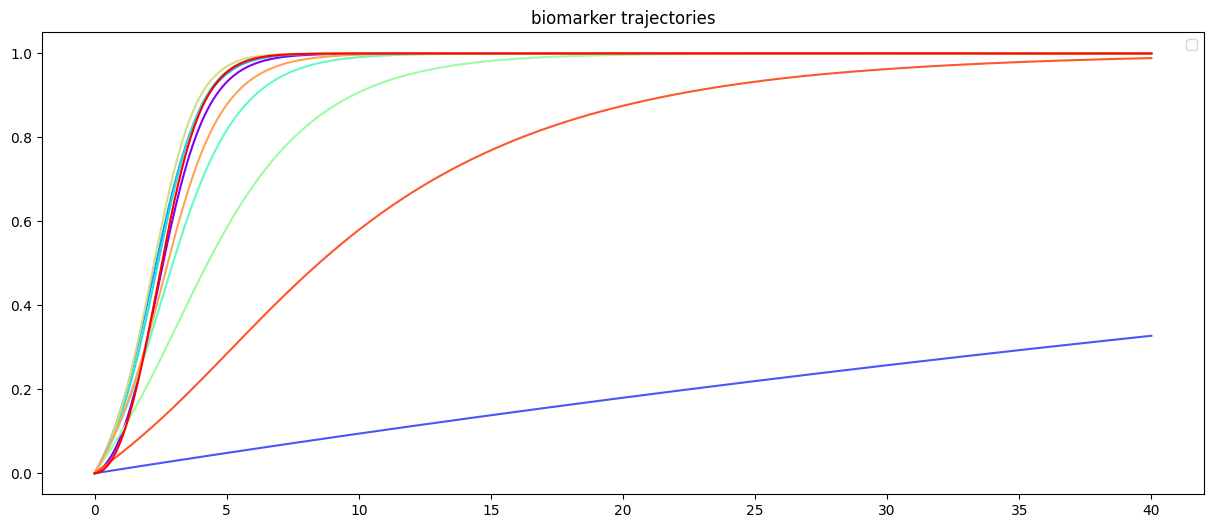

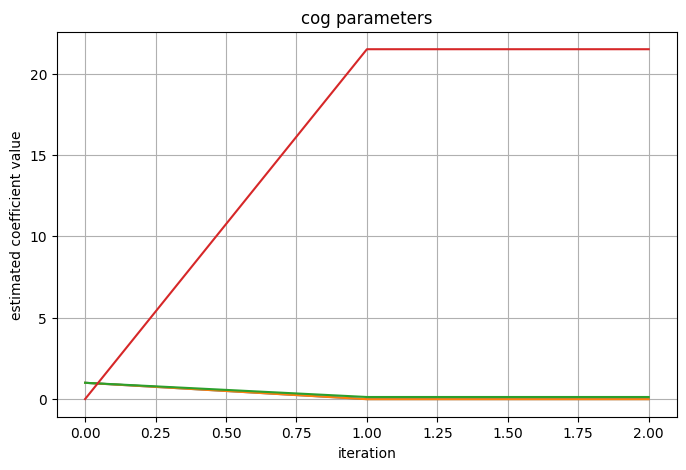

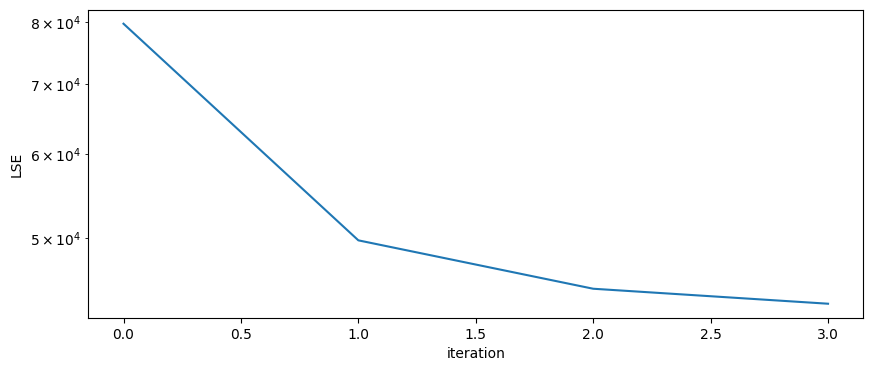

In [24]:
n_biomarkers = 10
t_span = np.linspace(0, 40, int(40/step))

theta_history = em_model_1.theta_history
beta_history = em_model_1.beta_history
lse_history = em_model_1.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history)

In [25]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac1_cog0_f01_sk1_betaREG"
em_model_2 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.0, lambda_f=0.1, lambda_scalar=1)
em_model_2.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init_reg)

NameError: name 'beta_init_reg' is not defined

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [0.178 0.552 0.    0.968 0.367 0.718 0.089 0.199 0.215 0.157]
s:  [2.386 2.335 2.437 1.897 3.137 2.624 2.324 2.639 2.205 2.156]
s_k:  0.8891622848533116
n_zeros: 5


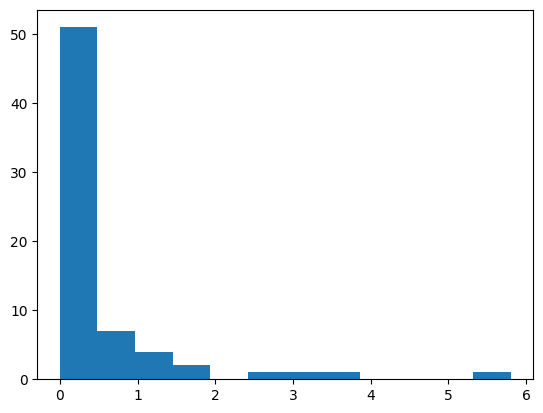


BETA SUMMARY:
beta initial:  [ 9.89  14.91  13.205 20.    10.455 12.503 20.    11.949 18.422 16.902]
beta final:  [ 9.89  14.91  13.205 20.    10.455 12.503 20.    11.949 18.422 16.902]


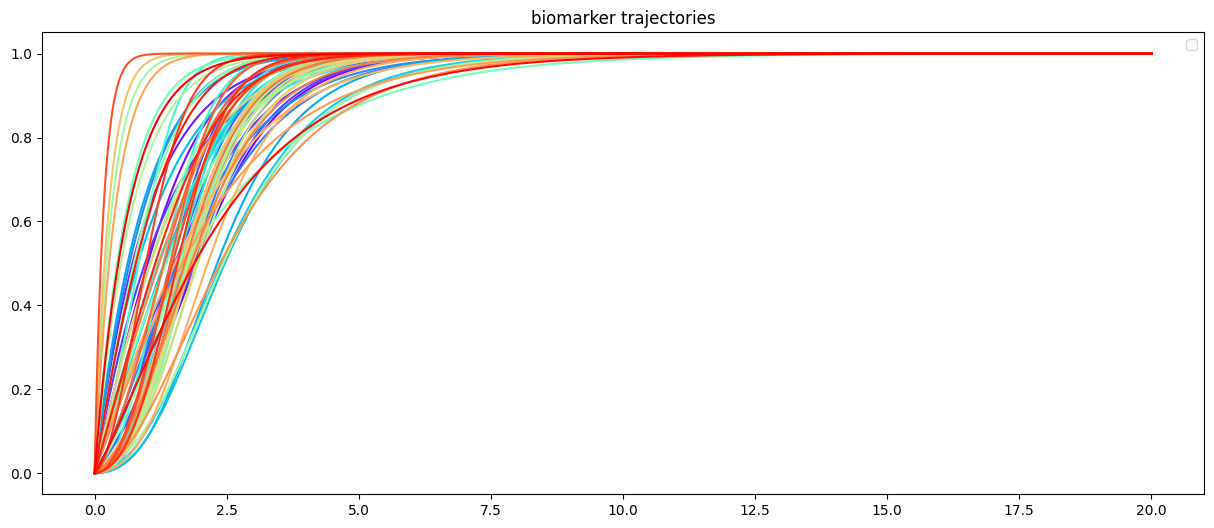

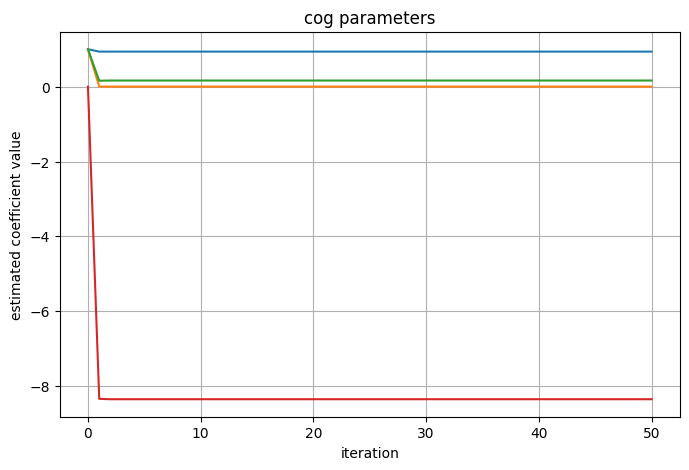

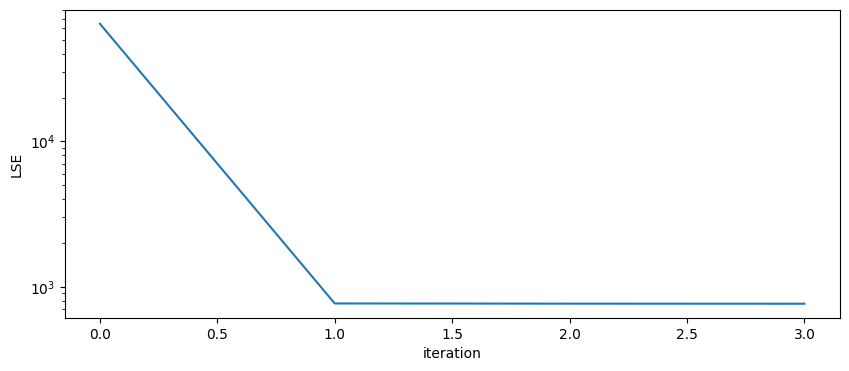

In [ ]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_2.theta_history
beta_history = em_model_2.beta_history
lse_history = em_model_2.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_0.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history[0:4])

In [ ]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter50_jac0_cog01_f05_sk1_betaREG"
em_model_3 = EM(num_iterations=50, t_max=t_max, step=step,
                 use_jacobian=False, lambda_cog=0.1, lambda_f=0.5, lambda_scalar=1)
em_model_3.fit(X=X, dt=dt, ids=ids, cog=cog, K=K, save_path=path, initial_beta=beta_init_reg)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

  4%|▍         | 2/50 [14:05<5:20:20, 400.43s/it]

  6%|▌         | 3/50 [14:16<2:54:25, 222.66s/it]

 88%|████████▊ | 44/50 [1:07:47<07:49, 78.27s/it]

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005]
s_k:  4.149
final theta:
f:  [0.    0.029 0.064 0.905 0.048 1.843 0.067 0.008 0.037 0.005]
s:  [2.386 2.335 2.437 1.898 3.137 2.624 2.323 2.639 2.205 2.156]
s_k:  1.9686325519747965
n_zeros: 11


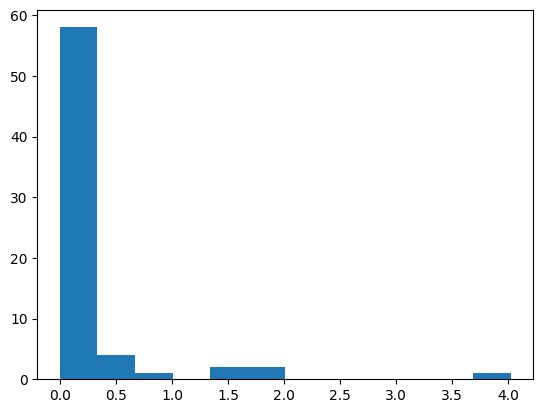


BETA SUMMARY:
beta initial:  [ 8. 20.  7.  7. 20. 20. 20. 20. 20. 20.]
beta final:  [ 8. 20.  7.  7. 20. 20. 20. 20. 20. 20.]


/home/dsemchin/Progression_models_simulations/EMDPM/visualization.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


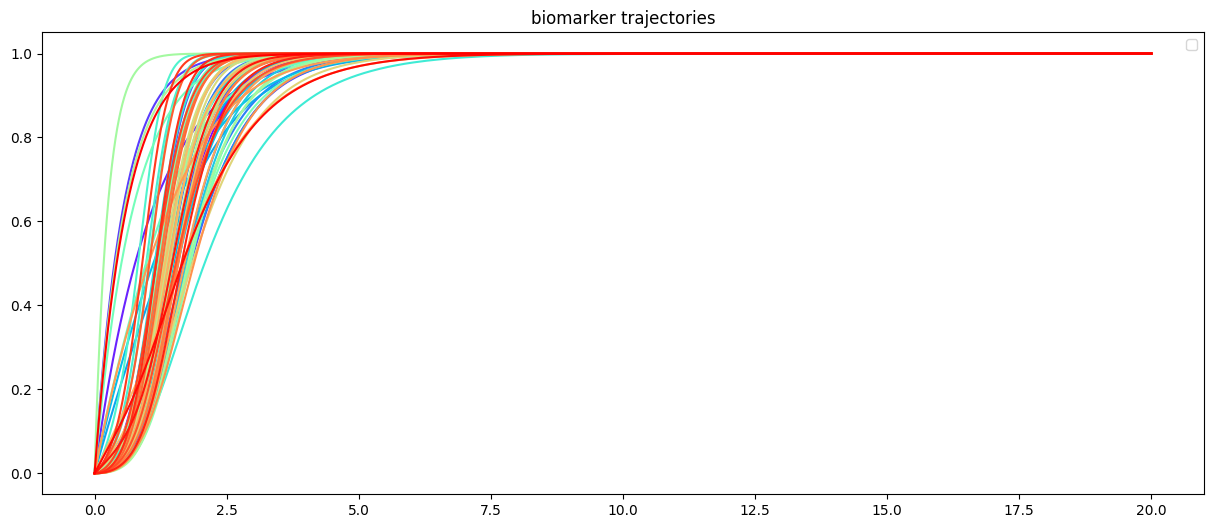

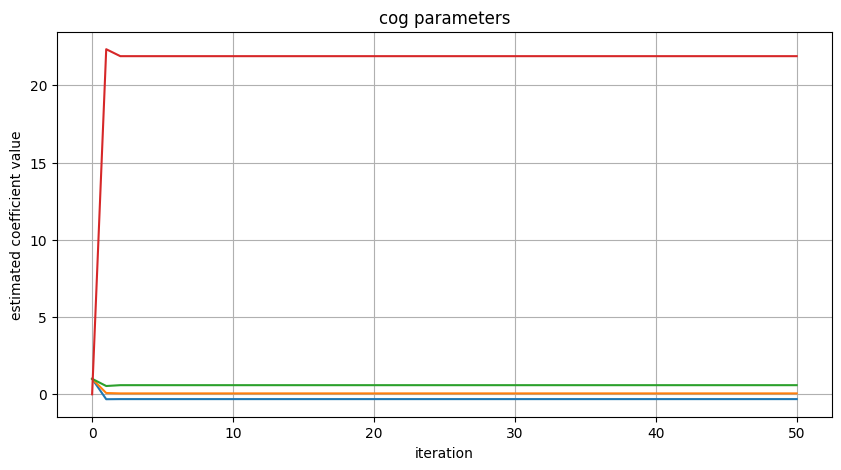

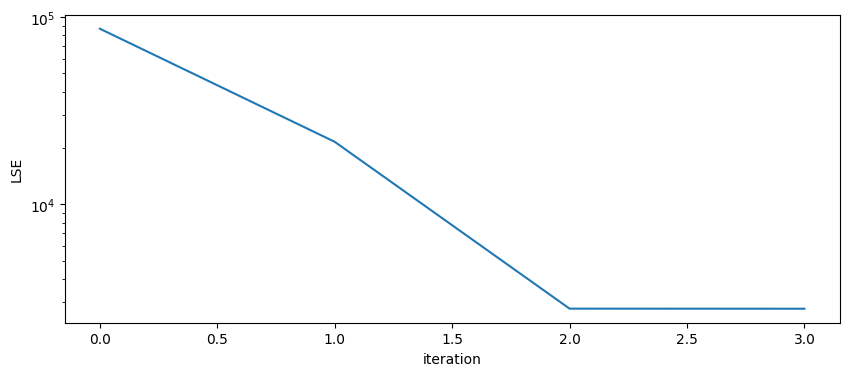

In [ ]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_3.theta_history
beta_history = em_model_3.beta_history
lse_history = em_model_3.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(initial_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", initial_theta[-1])

print("final theta:")
print("f: ", np.round(final_theta[:n_biomarkers], 3)[0:10])
print("s: ", np.round(final_theta[n_biomarkers:2*n_biomarkers], 3)[0:10])
print("s_k: ", final_theta[-1])

zeros = np.sum(final_theta[:n_biomarkers] == 0.0)
print(f"n_zeros: {zeros}")
plt.figure()
plt.hist(final_theta[:n_biomarkers], bins=12) 
plt.show()

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(beta_history[0:10, 0], 3))
print("beta final: ", np.round(beta_history[0:10, -1], 3))

plot_biomarker_trajectories(final_model, t_span, n_biomarkers)
plot_cog_regression_history(em_model_3.cog_regression_history, ["MCATOT","TD_score","PIGD_score"])
plot_lse(lse_history[0:4])